In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, PReLU, Dense, LSTM, multiply, concatenate, Activation
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt #for imshow
from matplotlib.collections import PatchCollection
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Model,Sequential
from sklearn.metrics import *
from keras.layers import Input,LSTM, Dense,RepeatVector,Embedding
from keras.utils import np_utils, plot_model
from keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df_tr = pd.read_csv('data_306k_TRAIN.csv')
df_val = pd.read_csv('data_306k_VAL.csv')
df_test = pd.read_csv('data_306k_TEST.csv')

In [107]:
train_1000_0 = df_tr.iloc[np.asarray(np.where(df_tr.iloc[:,0]==0)).tolist()[0],:].iloc[:,df_tr.columns != 'dataset_test2'].sample(n=1000)
train_1000_1 = df_tr.iloc[np.asarray(np.where(df_tr.iloc[:,0]==1)).tolist()[0],:].iloc[:,df_tr.columns != 'dataset_test2'].sample(n=1000)
train_1000_2 = df_tr.iloc[np.asarray(np.where(df_tr.iloc[:,0]==2)).tolist()[0],:].iloc[:,df_tr.columns != 'dataset_test2'].sample(n=1000)
train_1000_3 = df_tr.iloc[np.asarray(np.where(df_tr.iloc[:,0]==3)).tolist()[0],:].iloc[:,df_tr.columns != 'dataset_test2'].sample(n=500)
train_1000 = train_1000_0.append(train_1000_1.append(train_1000_2.append(train_1000_3)))

In [128]:
#for unequal proportion
train_1000 = df_tr.sample(n=3500)
val_500 = df_val.sample(n=500)
test_500 = df_test.sample(n=500)

In [135]:
#Train set 
X_train = train_1000.iloc[:,2:452].values #change the bracket
y_train = train_1000.iloc[:,0].values

#Val set
X_val = val_500.iloc[:,2:452].values
y_val = val_500.iloc[:,0].values

#Test set
X_test = test_500.iloc[:,2:452].values
y_test = test_500.iloc[:,0].values

In [137]:
X_train = X_train.reshape(X_train.shape[0],1, 450)
X_test = X_test.reshape(X_test.shape[0], 1, 450)
X_val = X_val.reshape(X_val.shape[0],1, 450)

y_val = np_utils.to_categorical(y_val, 4)
y_test = np_utils.to_categorical(y_test, 4)
y_train = np_utils.to_categorical(y_train, 4)


Evaluating : 
Train on 3500 samples, validate on 500 samples
Epoch 1/150
3500/3500 [==============================] - 55s 16ms/step - loss: 0.7328 - acc: 0.6934 - val_loss: 0.6624 - val_acc: 0.6920
Epoch 2/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.6486 - acc: 0.7197 - val_loss: 0.7882 - val_acc: 0.6300
Epoch 3/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.6321 - acc: 0.7266 - val_loss: 4.3001 - val_acc: 0.2440
Epoch 4/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.6165 - acc: 0.7386 - val_loss: 0.7116 - val_acc: 0.6780
Epoch 5/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.6077 - acc: 0.7406 - val_loss: 2.4521 - val_acc: 0.2480
Epoch 6/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.6006 - acc: 0.7457 - val_loss: 1.0482 - val_acc: 0.6280
Epoch 7/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.6003 - acc: 0.7426 - val_loss: 0.94

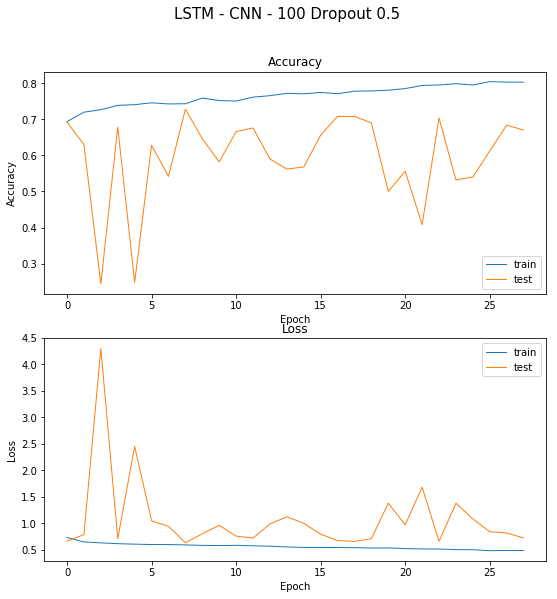

In [138]:
MAX_SEQUENCE_LENGTH = 450
NB_CLASS = 4

TRAINABLE = True


def generate_model():
    ip = Input(shape=(1, MAX_SEQUENCE_LENGTH))

    x = LSTM(100)(ip)
    x = Dropout(0.5)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128,10,padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(128,10, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(NB_CLASS, activation='softmax')(x)

    model = Model(ip, out)

    #model.summary()

    # add load model code here to fine-tune

    return model
x = X_train
y = y_train
model = generate_model()
optm = Adam(lr=1e-3)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

print("\nEvaluating : ")
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train,y_train,
                             epochs = 150,
                             batch_size=32,
                             verbose = 1,
                             validation_data = (X_val,y_val),
                             callbacks = cb)
    # 10. Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=1)
print('Test accuarcy:', str(score))

predictions = model.predict([X_test])

real_labels = np.argmax(y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('LSTM - CNN - 100 Dropout 0.5', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 

#model.save('timeseries_lstm_cnn_50epochs.h5')
#return accuracy


Evaluating : 
Train on 3500 samples, validate on 500 samples
Epoch 1/150
3500/3500 [==============================] - 55s 16ms/step - loss: 0.9475 - acc: 0.5534 - val_loss: 1.3023 - val_acc: 0.4200
Epoch 2/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.8446 - acc: 0.6126 - val_loss: 0.7849 - val_acc: 0.6720
Epoch 3/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.8178 - acc: 0.6317 - val_loss: 1.1214 - val_acc: 0.4500
Epoch 4/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.7962 - acc: 0.6397 - val_loss: 0.7104 - val_acc: 0.6780
Epoch 5/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.7761 - acc: 0.6554 - val_loss: 2.0501 - val_acc: 0.3020
Epoch 6/150
3500/3500 [==============================] - 51s 14ms/step - loss: 0.7820 - acc: 0.6411 - val_loss: 0.6716 - val_acc: 0.7200
Epoch 7/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.7673 - acc: 0.6694 - val_loss: 1.19

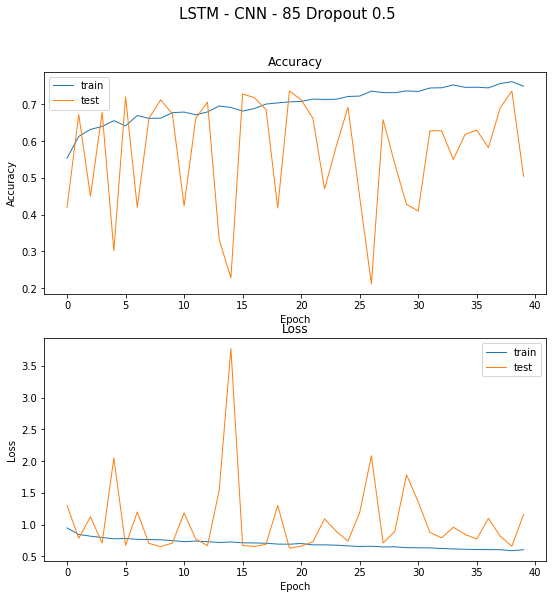

In [124]:
MAX_SEQUENCE_LENGTH = 450
NB_CLASS = 4

TRAINABLE = True


def generate_model():
    ip = Input(shape=(1, MAX_SEQUENCE_LENGTH))

    x = LSTM(85)(ip)
    x = Dropout(0.5)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128,10,padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(128,10, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(NB_CLASS, activation='softmax')(x)

    model = Model(ip, out)

    #model.summary()

    # add load model code here to fine-tune

    return model
x = X_train
y = y_train
model = generate_model()
optm = Adam(lr=1e-3)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

print("\nEvaluating : ")
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train,y_train,
                             epochs = 150,
                             batch_size=32,
                             verbose = 1,
                             validation_data = (X_val,y_val),
                             callbacks = cb)
    # 10. Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=1)
print('Test accuarcy:', str(score))

predictions = model.predict([X_test])

real_labels = np.argmax(y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('LSTM - CNN - 85 Dropout 0.5', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 

#model.save('timeseries_lstm_cnn_50epochs.h5')
#return accuracy


Evaluating : 
Train on 3500 samples, validate on 500 samples
Epoch 1/150
3500/3500 [==============================] - 55s 16ms/step - loss: 0.9262 - acc: 0.5569 - val_loss: 1.5104 - val_acc: 0.3820
Epoch 2/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.8380 - acc: 0.6123 - val_loss: 0.9401 - val_acc: 0.4980
Epoch 3/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.8276 - acc: 0.6206 - val_loss: 0.9981 - val_acc: 0.4440
Epoch 4/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.8024 - acc: 0.6311 - val_loss: 0.7308 - val_acc: 0.6020
Epoch 5/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.7898 - acc: 0.6523 - val_loss: 1.0320 - val_acc: 0.5160
Epoch 6/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.7851 - acc: 0.6491 - val_loss: 0.9700 - val_acc: 0.5340
Epoch 7/150
3500/3500 [==============================] - 50s 14ms/step - loss: 0.7708 - acc: 0.6643 - val_loss: 1.27

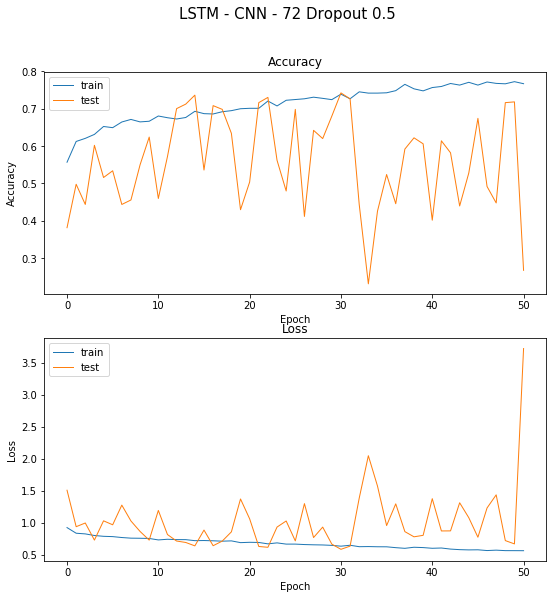

In [125]:
MAX_SEQUENCE_LENGTH = 450
NB_CLASS = 4

TRAINABLE = True


def generate_model():
    ip = Input(shape=(1, MAX_SEQUENCE_LENGTH))

    x = LSTM(72)(ip)
    x = Dropout(0.5)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128,10,padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(128,10, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(NB_CLASS, activation='softmax')(x)

    model = Model(ip, out)

    #model.summary()

    # add load model code here to fine-tune

    return model
x = X_train
y = y_train
model = generate_model()
optm = Adam(lr=1e-3)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

print("\nEvaluating : ")
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train,y_train,
                             epochs = 150,
                             batch_size=32,
                             verbose = 1,
                             validation_data = (X_val,y_val),
                             callbacks = cb)
    # 10. Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=1)
print('Test accuarcy:', str(score))

predictions = model.predict([X_test])

real_labels = np.argmax(y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('LSTM - CNN - 72 Dropout 0.5', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 

#model.save('timeseries_lstm_cnn_50epochs.h5')
#return accuracy

In [127]:
MAX_SEQUENCE_LENGTH = 450
NB_CLASS = 4

TRAINABLE = True


def generate_model():
    ip = Input(shape=(1, MAX_SEQUENCE_LENGTH))

    x = LSTM(128)(ip)
    x = Dropout(0.5)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(150,10,padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(150,10, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(NB_CLASS, activation='softmax')(x)

    model = Model(ip, out)

    #model.summary()

    # add load model code here to fine-tune

    return model
x = X_train
y = y_train
model = generate_model()
optm = Adam(lr=1e-3)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

print("\nEvaluating : ")
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train,y_train,
                             epochs = 150,
                             batch_size=32,
                             verbose = 1,
                             validation_data = (X_val,y_val),
                             callbacks = cb)
    # 10. Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=1)
print('Test accuarcy:', str(score))

predictions = model.predict([X_test])

real_labels = np.argmax(y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('LSTM - CNN - 64 Dropout 0.5', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 

#model.save('timeseries_lstm_cnn_50epochs.h5')
#return accuracy


Evaluating : 
Train on 3500 samples, validate on 500 samples
Epoch 1/150
3500/3500 [==============================] - 61s 17ms/step - loss: 0.9194 - acc: 0.5634 - val_loss: 1.2850 - val_acc: 0.4240
Epoch 2/150
3500/3500 [==============================] - 56s 16ms/step - loss: 0.8329 - acc: 0.6311 - val_loss: 1.5190 - val_acc: 0.3960
Epoch 3/150
3500/3500 [==============================] - 57s 16ms/step - loss: 0.8296 - acc: 0.6211 - val_loss: 0.8433 - val_acc: 0.5340
Epoch 4/150
3500/3500 [==============================] - 57s 16ms/step - loss: 0.8084 - acc: 0.6374 - val_loss: 0.7522 - val_acc: 0.6280
Epoch 5/150
3500/3500 [==============================] - 57s 16ms/step - loss: 0.7947 - acc: 0.6429 - val_loss: 0.8327 - val_acc: 0.5260
Epoch 6/150
3500/3500 [==============================] - 58s 17ms/step - loss: 0.7734 - acc: 0.6529 - val_loss: 0.7842 - val_acc: 0.5640
Epoch 7/150
3500/3500 [==============================] - 58s 16ms/step - loss: 0.7634 - acc: 0.6649 - val_loss: 0.71

KeyboardInterrupt: 

In [62]:
 class lstm_RNN:
    def __init__(self):
        self.history = None
        
        print('Build model...')
        self.model = Sequential()
        #self.model.add(Embedding(input_dim=X_train.shape[0], output_dim=1,input_length=450))
        self.model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[2]),
                       return_sequences=True))
        self.model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
        self.model.add(Dense(128))
        #self.model.add(Dense(128))
        self.model.add(Dense(4, activation='sigmoid'))
        
        print("Input: {}".format(self.model.input_shape))
        print("Outputs: {}".format(self.model.output_shape))
        print("Actual Input: {}".format(X_train.shape))
        print("Actual Output: {}".format(y_train.shape))
        #self.model = Sequential()
        #self.model.add(LSTM(100, batch_input_shape=(28,X_train.shape[1], X_train.shape[2]),stateful=True))
        #self.model.add(RepeatVector(600))
        #self.model.add(Dropout(0.2))
        #self.model.add(LSTM(50, ret))
        #self.model.add(BatchNormalization())
        #self.model.add(LSTM(200))
        #self.model.add(Activation('relu'))
        #self.model.add(Dropout(0.3))
        #self.model.add(Dense(2, activation = 'sigmoid', #change to 1 for binary_crossentropy
                # kernel_initializer = 'TruncatedNormal',
                #kernel_regularizer = l2(0.1)))
    
    def train(self, X_train, y_train,X_test,y_test,n_epochs = 50):
        self.model.compile(loss = 'categorical_crossentropy',
                          optimizer = 'adam',
                          metrics = ['accuracy'])
        #cb = [ReduceLROnPlateau(monitor='loss', patience=15, factor = 0.5)]
        cb = [EarlyStopping(monitor = 'val_loss', patience = 35)]
        self.history = self.model.fit(X_train,y_train,
                                     epochs = n_epochs,
                                     batch_size=20,
                                     verbose = 1,
                                     validation_data = (X_test,y_test),
                                     callbacks = cb)
    def predict(self, X_test):
        self.predict_labels = self.model.predict(X_test)
        return self.predict_labels
    def plot_history(self):
        plt.figure(1)
        plt.subplot(211)  
        plt.plot(self.history.history['acc'], linewidth = 1.0)  
        plt.plot(self.history.history['val_acc'], linewidth = 1.0)  
        plt.title('Accuracy')  
        plt.ylabel('Accuracy')  
        plt.xlabel('Epoch')  
        plt.legend(['train', 'test'], loc='best') 

        plt.subplot(212)  
        plt.plot(self.history.history['loss'], linewidth = 1.0)  
        plt.plot(self.history.history['val_loss'], linewidth = 1.0)  
        plt.title('Loss')  
        plt.ylabel('Loss')  
        plt.xlabel('Epoch')  
        plt.legend(['train', 'test'], loc='best')  
        plt.show() 

Build model...
Input: (None, 1, 450)
Outputs: (None, 4)
Actual Input: (1000, 1, 450)
Actual Output: (1000, 4)
Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 3s 3ms/step - loss: 1.2290 - acc: 0.4960 - val_loss: 1.0296 - val_acc: 0.5580
Epoch 2/50
1000/1000 [==============================] - 0s 385us/step - loss: 1.0561 - acc: 0.4980 - val_loss: 1.0178 - val_acc: 0.5580
Epoch 3/50
1000/1000 [==============================] - 0s 386us/step - loss: 1.0444 - acc: 0.5000 - val_loss: 1.0180 - val_acc: 0.5620
Epoch 4/50
1000/1000 [==============================] - 0s 389us/step - loss: 1.0304 - acc: 0.5090 - val_loss: 1.0179 - val_acc: 0.5680
Epoch 5/50
1000/1000 [==============================] - 0s 376us/step - loss: 1.0096 - acc: 0.5260 - val_loss: 0.9994 - val_acc: 0.5720
Epoch 6/50
1000/1000 [==============================] - 0s 379us/step - loss: 0.9922 - acc: 0.5420 - val_loss: 0.9927 - val_acc: 0.5880
Epoch 7/50
1000/1000 [=======

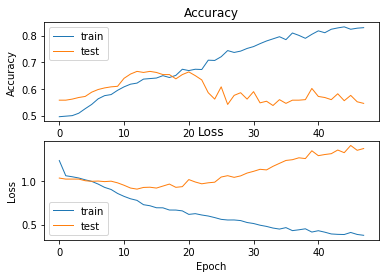

In [63]:
    RNN = lstm_RNN()
    RNN.train(X_train, y_train,X_test, y_test)
    Y_pred = RNN.predict(X_test)
    Y_pred = Y_pred.round()
    print(Y_pred)
    real_labels = np.argmax(y_test, axis=1)
    p_labels = np.argmax(Y_pred, axis=1)

    print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

    RNN.plot_history()